# Pancreatic endocrinogenesis

In this tutorial we will visualize the development of pancreatic cells. 

Remark: We recommend using 3D interactive plots when visualizing data. Unfortunately, these plots are not compatible with ReadTheDocs documentation website, so here we show only static 2D plots.

In [1]:
import ocelli as oci
import scvelo as scv
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

Firstly, the dataset is imported.

In [2]:
x = scv.datasets.pancreas()
x

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Dataset consists of 3696 cells split into 8 celltypes.

In [3]:
from collections import Counter

Counter(x.obs['clusters'])

Counter({'Pre-endocrine': 592,
         'Ductal': 916,
         'Alpha': 481,
         'Ngn3 high EP': 642,
         'Delta': 70,
         'Beta': 591,
         'Ngn3 low EP': 262,
         'Epsilon': 142})

The gene expression matrix is stored in x.X. Our first step is to perform topic modeling analysis on this matrix and then generate views. Each view will correspend to a single topic.

In [4]:
oci.pp.latent_dirichlet_allocation(x, n_topics=20, max_iter=70)
oci.pp.generate_views(x)
x

20 topics calculated.
20 topic-based views generated and normalized.


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'lda_params', 'top_vars', 'view_keys'
    obsm: 'X_pca', 'X_umap', 'lda', 'view0', 'view1', 'view2', 'view3', 'view4', 'view5', 'view6', 'view7', 'view8', 'view9', 'view10', 'view11', 'view12', 'view13', 'view14', 'view15', 'view16', 'view17', 'view18', 'view19'
    varm: 'lda'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

Then, the gene expression matrix together with dataset's spliced and unspliced layers are normalized so that [scVelo](https://scvelo.readthedocs.io) RNA velocity estimation can be run.

In [5]:
scv.pp.normalize_per_cell(x, counts_per_cell_after=10000)
scv.pp.log1p(x)
scv.tl.velocity(x, mode='stochastic')
scv.tl.velocity_graph(x)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:11) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Now, we move to the standard MVDM pipeline. 

Firstly, multi-view weights are calculated.

In [6]:
oci.pp.neighbors(x, n_neighbors=20, mode='sklearn')
oci.tl.weights(x)

20 nearest neighbors calculated.
Multi-view weights estimated.


Secondly, the multi-view diffusion maps components are calculated.

In [7]:
oci.tl.multi_view_diffusion_maps(x, n_comps=20)

20 multi-view diffusion maps components calculated.


And lastly, the RNA velocity graph is constructed and visualized.

In [8]:
oci.pp.neighbors(x, n_neighbors=100, neighbors_key='neighbors_mvdm', view_keys=['x_mvdm'])
oci.tl.vel_graph(x, n=20, neighbors_key='neighbors_mvdm')
oci.tl.forceatlas2(x, n_steps=4000, is2d=True)

100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Apr 24, 2022 2:34:55 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Apr 24, 2022 2:34:56 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Apr 24, 2022 2:34:56 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,161 added)


*************************25%
*************************50%
*************************75%
****

*********************100%
Time = 37.505s


(<Figure size 1800x1200 with 20 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>,
         <AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

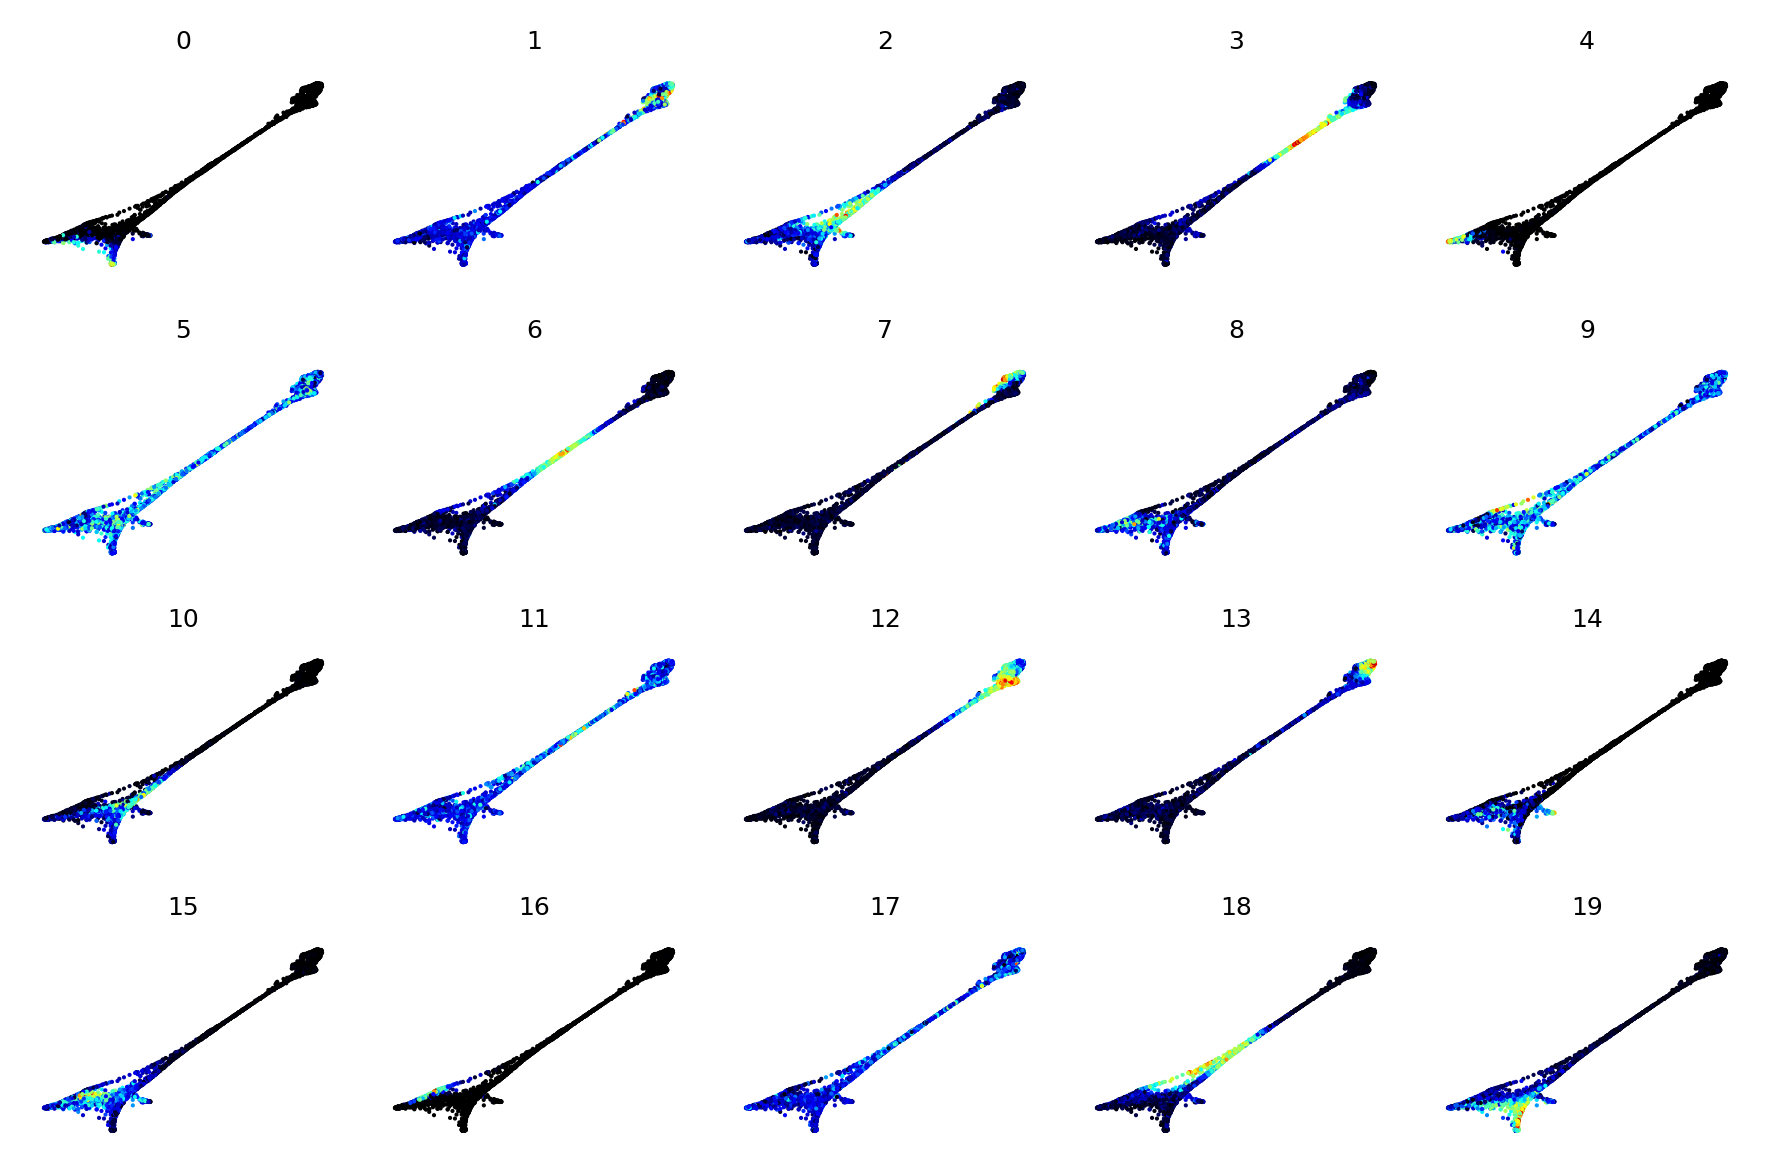

In [9]:
oci.pl.topics(x, x_key='x_fa2')

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

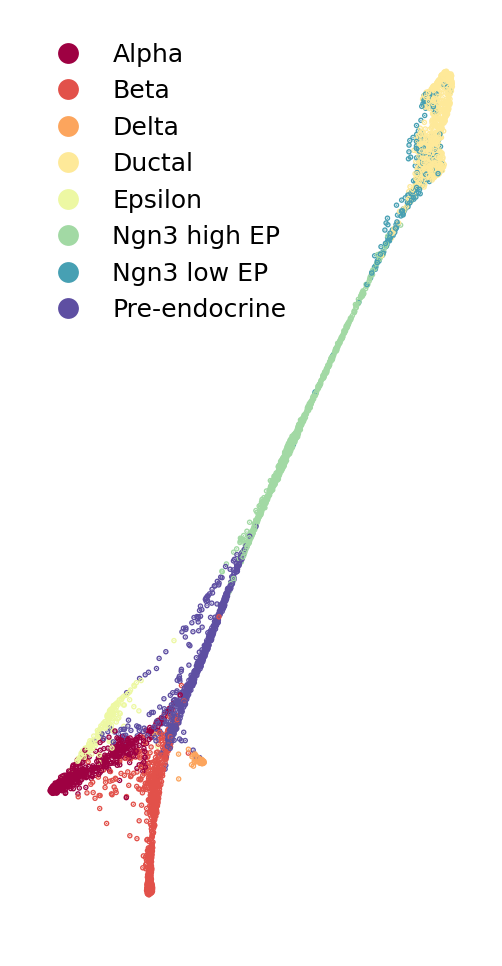

In [10]:
oci.pl.scatter(x, x_key='x_fa2', color_key='clusters', static=True, marker_size=0.1)